In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sbn 

import statsmodels.api as sm
from statsmodels.formula.api import ols, logit

import os 

# Aggregate results

The results of the sensitivity analysis (outputs of running ```$ python HER2_sensitivity_runs.sh```) are saved in the realative path `OUT_DIR`, which will need to be manually set in the next cell. The results of each analysis (with different hyper parameters) will be aggregated into final dataframes for use in making final resistance/sensitivity calls. If there are questions or concerns with any specific set of hyper-parameters, the figures out output files are available for inspection. 

In [2]:
OUT_DIR = './neratinib_output/'
CSV_OUT = './neratinib_SKBR3_results.csv'

df = [] 
df2 = []
for run in os.listdir(OUT_DIR): 
    run_res_path = OUT_DIR + run + '/run_results.csv'
    if os.path.exists(run_res_path): 
        df.append( pd.read_csv(run_res_path) ) 
    else: 
        print(f'Directory not found! run id: {run}')
        
    prob_res_path = OUT_DIR + run + '/unlabeled_lines_results.csv' 
    if os.path.exists(prob_res_path): 
        prob_res = pd.read_csv(prob_res_path).assign(run_id=run)
        df2.append(prob_res)
        
run_res = pd.concat(df, axis=0, ignore_index=True)
prob_res = pd.concat(df2, axis=0, ignore_index=True).rename({'Unnamed: 0':'obs_id'}, axis=1)
prob_res.head()

,obs_id,pc1,pc2,treatment,mutant,exp_set,prob_res,prob_sens,call,odds_ratio,batch,PC1_batch_pval,PC1_batch_flag,PC2_batch_pval,PC2_batch_flag,drug,cell_track_count,low_data_flag,run_id
0,0,0.219585,0.043269,neratinib,ND611,H210205_Set1_2,0.039922,0.960078,sens,0.041582,H210205_Set1_2,0.372182,False,0.065968,False,neratinib,1159,False,01946e65-dd74-460a-9b87-5c07aafe5759
1,1,0.234554,0.021988,neratinib,ND611,H210326_Set1,0.040474,0.959526,sens,0.042181,H210326_Set1,0.921107,False,0.154180,False,neratinib,1159,False,01946e65-dd74-460a-9b87-5c07aafe5759
2,2,0.223906,0.011933,neratinib,R678Q,H210423_Set1,0.040965,0.959035,sens,0.042715,H210423_Set1,0.757354,False,0.441946,False,neratinib,350,False,01946e65-dd74-460a-9b87-5c07aafe5759
3,3,0.205876,0.032010,neratinib,A1160V,H210409_Set1,0.041206,0.958794,sens,0.042977,H210409_Set1,0.929283,False,0.945408,False,neratinib,109,False,01946e65-dd74-460a-9b87-5c07aafe5759
4,4,0.204489,0.036558,neratinib,T306M,H210205_Set1_2,0.041444,0.958556,sens,0.043236,H210205_Set1_2,0.372182,False,0.065968,False,neratinib,180,False,01946e65-dd74-460a-9b87-5c07aafe5759


In [3]:
run_res.head()

,Unnamed: 0,accuracy(train),pc1_var,pc2_var,kmeans_inertia,res_line,sens_line,drug,nclus,resample_sz,load,burnin,run_id
0,0,1.0,0.451086,0.115006,2.142242,T798I,WT,neratinib,20,75,normalized,0,01946e65-dd74-460a-9b87-5c07aafe5759
1,0,1.0,0.503888,0.114101,2.019470,T798I,WT,neratinib,20,75,raw,10,01df38d4-be4f-467e-9d15-2298d9b21e88
2,0,1.0,0.505402,0.117029,3.717519,T798I,WT,neratinib,15,125,normalized,0,022fcd1a-2077-48fe-8cd2-1f751f770ef1
3,0,1.0,0.509594,0.109633,3.624761,T798I,WT,neratinib,20,125,raw,10,02a34f87-7476-478e-9699-9918e5c44cb6
4,0,1.0,0.490216,0.122273,3.705506,T798I,WT,neratinib,15,125,normalized,0,02d5eb1d-3742-4408-a568-b6bd9392a352


In [4]:
exp_params = run_res[['nclus', 'resample_sz', 'load', 'burnin']].drop_duplicates()
all_data = prob_res.merge(run_res, on='run_id')

--- 

# Summary

In [5]:
print('# of experiment hyper-parameters tested:', len(exp_params))
print('# of mutants:', prob_res.mutant.unique().shape[0])
print('# of experiments:', prob_res.exp_set.unique().shape[0])
print(f'# of treatments: {prob_res.treatment.unique().shape[0]} [{prob_res.treatment.unique()}]')

# of experiment hyper-parameters tested: 90
# of mutants: 83
# of experiments: 13
# of treatments: 1 [['neratinib']]


---

# Batch effect flags 

Each analysis will assign two batch effect flags (for PC1 & PC2, independantly). This is done by running a regression to predict  the respective principle component from the experiment set (controls only); If the subsequent ANOVA shows a significant experiment set coefficient (p-val less that 0.05), than the flag is set. 

In [6]:
# test if any hyperparameters are predictive of low batch effect p-values. 
lm = ols('PC1_batch_pval ~ nclus + resample_sz + load + burnin', data=all_data).fit(maxiter=50) #Specify C for Categorical
print( lm.summary() )

                            OLS Regression Results                            
Dep. Variable:         PC1_batch_pval   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     333.9
Date:                Thu, 08 Jul 2021   Prob (F-statistic):          1.05e-283
Time:                        10:35:10   Log-Likelihood:                -915.63
No. Observations:               45000   AIC:                             1841.
Df Residuals:                   44995   BIC:                             1885.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6821      0.006    106.362      

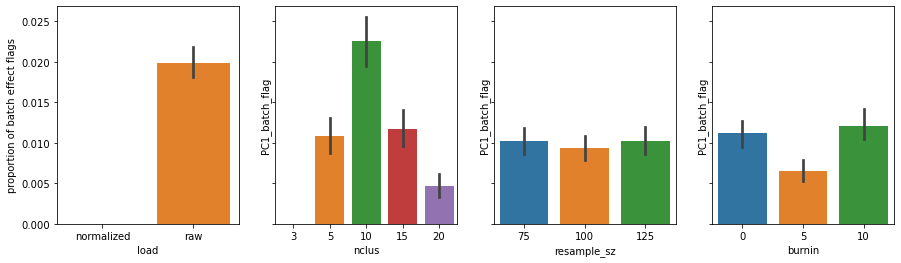

<Figure size 432x288 with 0 Axes>

In [7]:
f, axes = plt.subplots(1,4, figsize = (15,4), sharey=True)

plt.figure()
sbn.barplot(x='load', y='PC1_batch_flag', data=all_data, ax=axes.flat[0])
axes.flat[0].set_ylabel('proportion of batch effect flags')
sbn.barplot(x='nclus', y='PC1_batch_flag', data=all_data, ax=axes.flat[1])
sbn.barplot(x='resample_sz', y='PC1_batch_flag', data=all_data, ax=axes.flat[2])
sbn.barplot(x='burnin', y='PC1_batch_flag', data=all_data, ax=axes.flat[3])
plt.show()

In [8]:
lm = ols('PC2_batch_pval ~ nclus + resample_sz + load + burnin', data=all_data).fit(maxiter=50) #Specify C for Categorical
print( lm.summary() )

                            OLS Regression Results                            
Dep. Variable:         PC2_batch_pval   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     485.5
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:35:12   Log-Likelihood:                -988.60
No. Observations:               45000   AIC:                             1987.
Df Residuals:                   44995   BIC:                             2031.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6169      0.006     96.031      

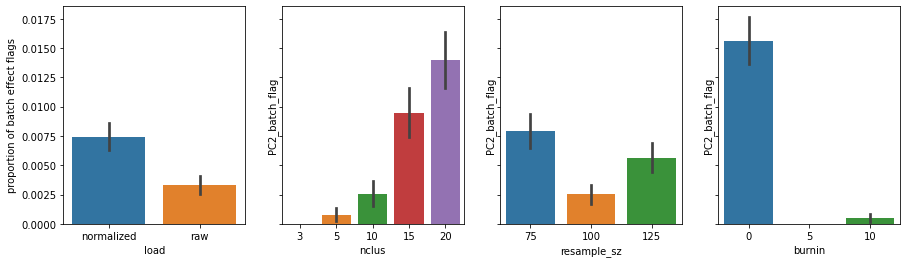

<Figure size 432x288 with 0 Axes>

In [9]:
f, axes = plt.subplots(1,4, figsize = (15,4), sharey=True)

plt.figure()
sbn.barplot(x='load', y='PC2_batch_flag', data=all_data, ax=axes.flat[0])
axes.flat[0].set_ylabel('proportion of batch effect flags')
sbn.barplot(x='nclus', y='PC2_batch_flag', data=all_data, ax=axes.flat[1])
sbn.barplot(x='resample_sz', y='PC2_batch_flag', data=all_data, ax=axes.flat[2])
sbn.barplot(x='burnin', y='PC2_batch_flag', data=all_data, ax=axes.flat[3])
plt.show()

## Did any one experiment have high batch effect flag proportions? 

In [10]:
# computing the average # of flags within each set + avg cell # of cell tracks 
# e.g., value of 0.14 for PC1_batch_flag below indicates that 14% of single analysis runs assigned a batch effect for PC1 in that experiment set. 
all_data.groupby('exp_set')[['low_data_flag', 'PC1_batch_flag', 'PC2_batch_flag', 'cell_track_count']].mean()

,low_data_flag,PC1_batch_flag,PC2_batch_flag,cell_track_count
exp_set,,,,
H210205_Set1_2,0.0,0.000000,0.017778,269.375000
H210205_Set2_2,0.0,0.000000,0.000000,322.000000
H210212_Set1,0.0,0.142222,0.033333,267.142857
H210212_Set2,0.0,0.000000,0.000000,200.625000
H210219_Set1,0.0,0.000000,0.000000,329.000000
H210219_Set2,0.0,0.000000,0.000000,293.375000
H210326_Set1,0.0,0.000000,0.020000,197.625000
H210326_Set2,0.0,0.000000,0.000000,223.625000
H210401_Set1,0.0,0.000000,0.000000,257.000000


# Low Data Flag 

Lowe data flags are set if any group (cell line, mutant, treatment) has less than 5% of the median number of cell tracks. 

In [11]:
prob_res[['mutant', 'low_data_flag']].low_data_flag.any()

False

# Train accuracy 

This quantifies how well the controls (resistant mutant and sensitive mutant under treatment) separate in PC-space. Poor training accuracy indicates that the analysis had a difficult time distinguishing sensitive response from resistant response, and so it's important to understand if any hyper parameters contribute to the separability. 

In [12]:
lm = ols('accuracy ~ nclus + resample_sz + load', data=run_res.rename({'accuracy(train)':'accuracy'}, axis=1)).fit() #Specify C for Categorical
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.758
Date:                Thu, 08 Jul 2021   Prob (F-statistic):             0.0110
Time:                        10:35:13   Log-Likelihood:                 1718.0
No. Observations:                 450   AIC:                            -3428.
Df Residuals:                     446   BIC:                            -3412.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0011      0.001    740.178      

# Concordant sensitive/resistance probabilities 

To examine the stability of the predicted probabilities **across replicates** (e.g., between analysis with different hyper-parameters), we can examine the clustered heatmap of predicted resistance probabilities. High positive correlation indicates that pairwise predicted probability between two analysis runs were the same or similar. *Negative correlation, or no correlation would indicate contridictory probability predictions.* 

/home/teddy/miniconda3/envs/HER2/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


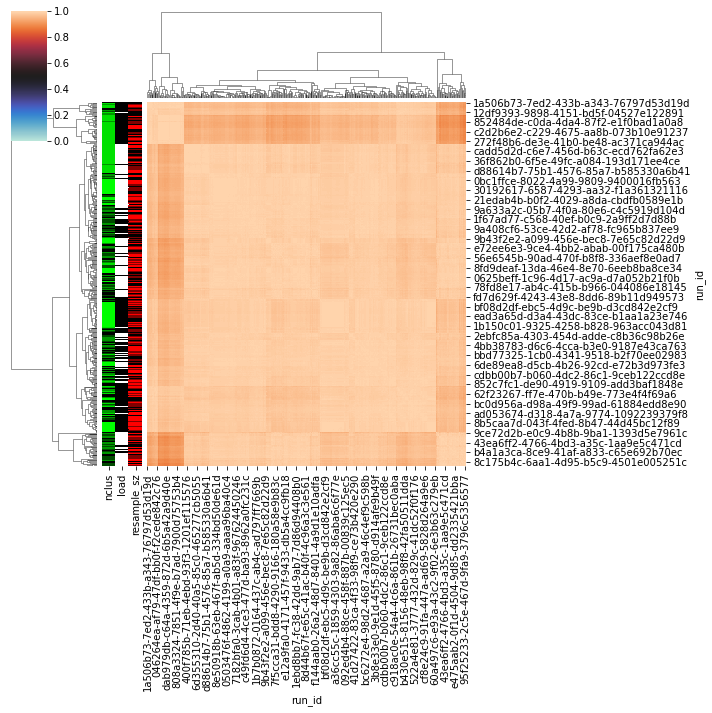

In [13]:
norm = lambda x, y: (x-min(y))/ (max(y) - min(y)) 

nclus_ = {row.run_id:[0., 1- norm(row.nclus,run_res.nclus),0., 0.5] for i,row in run_res.iterrows()}
nclus_colors = run_res['run_id'].map(nclus_).rename('nclus')

load_ = {row.run_id:'k' if (row.load == 'normalized') else 'w' for i,row in run_res.iterrows()}
load_colors = run_res['run_id'].map(load_).rename('load')

resamp_ = {row.run_id:[1 - norm(row.resample_sz,run_res.resample_sz), 0., 0., 0.5] for i,row in run_res.iterrows()}
resamp_colors = run_res['run_id'].map(resamp_).rename('resample_sz')

row_colors = pd.concat([nclus_colors, load_colors, resamp_colors], axis=1)
row_colors = row_colors.set_index(run_res.run_id)

#print(row_colors)

#ids_tokeep = run_res[lambda x: (x.nclus < 35)].run_id.values
#prob_res2 = prob_res[lambda x: x.run_id.isin(ids_tokeep)]

prob_res2 = prob_res.merge(run_res, on='run_id').pivot(columns='run_id', index='obs_id', values='prob_res')
res_mat = prob_res2.corr().fillna(0)
sbn.clustermap(res_mat, vmin=0, vmax=1, center=0.5, row_colors=row_colors, figsize=(10,10))

# Consensus Probability/Resistance Calls 

Using the results of all analysis runs (with different configurations) we can assign sens/res labels based on the consensus calls. 

In [37]:
conc_calls = prob_res.groupby(['mutant', 'call']).count()[['run_id']].reset_index().set_index('mutant') \
                    .pivot(columns='call', values='run_id').fillna(value=0) \
                    .assign(prop_call_res=lambda x: x.res / (x.res + x.sens + x['no-call']))\
                    .assign(prop_call_sens=lambda x: x.sens / (x.res + x.sens + x['no-call']))\
                    .assign(prop_call_nocall=lambda x: x['no-call'] / (x.res + x.sens + x['no-call']))

conc_calls = conc_calls.merge(prob_res[['mutant', 'cell_track_count', 'low_data_flag']].drop_duplicates(), on='mutant')
conc_calls = conc_calls.merge(prob_res[['mutant', 'PC1_batch_flag', 'PC2_batch_flag']].groupby('mutant').agg('mean').reset_index())
conc_calls = conc_calls.rename({'PC1_batch_flag': 'prop_PC1_batch_flag', 'PC2_batch_flag': 'prop_PC2_batch_flag'}, axis=1)

In [38]:
# should be (83, 10)
conc_calls.shape

(83, 11)

In [39]:
# should have no na's (e.g., empty is good)
conc_calls[conc_calls.isna().values.any(axis=1)]

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag


In [40]:
# 90 single-analysis runs * 5 replicats = 450 
# some mutants were run twice 
# ND611/T798I/WT are run with every experiment (90*5*13 experiments = 5850)
conc_calls[['no-call', 'res', 'sens']].sum(axis=1).unique()

array([ 450.,  900., 5850.])

In [41]:
# save concordant calls to file 
conc_calls.to_csv(CSV_OUT)

## Sorted by proportion of calls made as `resistant`

In [42]:
conc_calls.sort_values('prop_call_res', ascending=False).head(10)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
35,L785F,0.0,450.0,0.0,1.000000,0.000000,0.000000,74,False,0.0,0.02
74,V797A,14.0,435.0,1.0,0.966667,0.002222,0.031111,104,False,0.0,0.00
23,G778S779INSLPS,25.0,421.0,4.0,0.935556,0.008889,0.055556,284,False,0.0,0.00
60,R929W,35.0,387.0,28.0,0.860000,0.062222,0.077778,148,False,0.0,0.00
81,Y722V773INSRDGE,75.0,374.0,1.0,0.831111,0.002222,0.166667,58,False,0.0,0.00
18,F976L,124.0,289.0,37.0,0.642222,0.082222,0.275556,72,False,0.0,0.00
33,L755S,190.0,226.0,34.0,0.502222,0.075556,0.422222,80,False,0.0,0.00
75,V842I,75.0,373.0,452.0,0.414444,0.502222,0.083333,268,False,0.0,0.00
82,Y835F,56.0,178.0,216.0,0.395556,0.480000,0.124444,126,False,0.0,0.00
56,R456C,106.0,156.0,188.0,0.346667,0.417778,0.235556,55,False,0.0,0.00


## Sorted by proportion of calls made as `sensitive`

In [43]:
conc_calls.sort_values('prop_call_sens', ascending=False).head(10)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
28,I886M,0.0,0.0,450.0,0.0,1.0,0.0,62,False,0.142222,0.033333
68,T479M,0.0,0.0,450.0,0.0,1.0,0.0,256,False,0.000000,0.000000
29,L1197F,0.0,0.0,450.0,0.0,1.0,0.0,148,False,0.000000,0.000000
30,L313V,0.0,0.0,450.0,0.0,1.0,0.0,103,False,0.000000,0.017778
31,L43V,0.0,0.0,450.0,0.0,1.0,0.0,83,False,0.000000,0.000000
32,L662V,0.0,0.0,450.0,0.0,1.0,0.0,225,False,0.000000,0.000000
66,T297I,0.0,0.0,450.0,0.0,1.0,0.0,46,False,0.000000,0.000000
59,R897G,0.0,0.0,450.0,0.0,1.0,0.0,51,False,0.000000,0.000000
72,V424I,0.0,0.0,450.0,0.0,1.0,0.0,163,False,0.000000,0.000000
37,M833I,0.0,0.0,450.0,0.0,1.0,0.0,53,False,0.000000,0.000000


## Sorted by proportion of calls made as `no-call`

In [44]:
conc_calls.sort_values('prop_call_nocall', ascending=False).head(5)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
34,L755T759DEL,381.0,63.0,6.0,0.140000,0.013333,0.846667,126,False,0.0,0.017778
33,L755S,190.0,226.0,34.0,0.502222,0.075556,0.422222,80,False,0.0,0.000000
50,R1153L,129.0,101.0,220.0,0.224444,0.488889,0.286667,126,False,0.0,0.000000
36,L869R,127.0,87.0,236.0,0.193333,0.524444,0.282222,61,False,0.0,0.020000
0,A1039T,126.0,29.0,295.0,0.064444,0.655556,0.280000,125,False,0.0,0.000000


In [45]:
conc_calls.sort_values('prop_PC1_batch_flag', ascending=False).head(5)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
13,E717K,10.0,44.0,396.0,0.097778,0.880000,0.022222,129,False,0.142222,0.033333
26,I435L,29.0,45.0,376.0,0.100000,0.835556,0.064444,191,False,0.142222,0.033333
21,G621AFS31,2.0,0.0,448.0,0.000000,0.995556,0.004444,84,False,0.142222,0.033333
28,I886M,0.0,0.0,450.0,0.000000,1.000000,0.000000,62,False,0.142222,0.033333
9,D769Y,38.0,145.0,267.0,0.322222,0.593333,0.084444,145,False,0.142222,0.033333


In [46]:
conc_calls.sort_values('prop_PC2_batch_flag', ascending=False).head(5)

,mutant,no-call,res,sens,prop_call_res,prop_call_sens,prop_call_nocall,cell_track_count,low_data_flag,prop_PC1_batch_flag,prop_PC2_batch_flag
14,E744D,44.0,58.0,348.0,0.128889,0.773333,0.097778,100,False,0.142222,0.033333
28,I886M,0.0,0.0,450.0,0.000000,1.000000,0.000000,62,False,0.142222,0.033333
21,G621AFS31,2.0,0.0,448.0,0.000000,0.995556,0.004444,84,False,0.142222,0.033333
26,I435L,29.0,45.0,376.0,0.100000,0.835556,0.064444,191,False,0.142222,0.033333
9,D769Y,38.0,145.0,267.0,0.322222,0.593333,0.084444,145,False,0.142222,0.033333


## Distribution of concordant resistance calls 

X-axis indicates the proportion of resistance calls made for a given mutant, and y-axis indicates the number of mutants in that range.

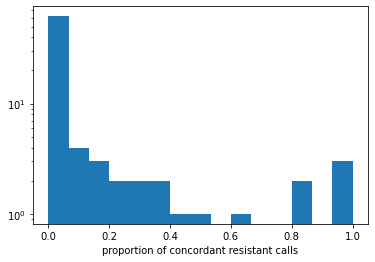

In [48]:
plt.figure()
plt.hist(conc_calls.prop_call_res, bins=15)
plt.yscale('log')
plt.xlabel('proportion of concordant resistant calls')
plt.show()

In [49]:
np.sum( conc_calls.prop_call_res > 0.75 )

5

In [50]:
# Most resistant mutants 
conc_res_obs_ids = conc_calls[conc_calls.prop_call_res > 0.75].reset_index().mutant.values
conc_res_obs_ids

array(['G778S779INSLPS', 'L785F', 'R929W', 'V797A', 'Y722V773INSRDGE'],
      dtype=object)

# Cell track correlation with resistance

One element to investigate as a potential confounding factor is how the number of cell tracks in a given group (cell line, mutant, treatment) correlates to the final assigned proportion of resistant calls. 

In [51]:
lm = ols('prop_call_res ~ cell_track_count', data=conc_calls[conc_calls.cell_track_count < 500]).fit(maxiter=50) #Specify C for Categorical
print( lm.summary() )

                            OLS Regression Results                            
Dep. Variable:          prop_call_res   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7271
Date:                Thu, 08 Jul 2021   Prob (F-statistic):              0.396
Time:                        10:47:41   Log-Likelihood:                0.51026
No. Observations:                  82   AIC:                             2.979
Df Residuals:                      80   BIC:                             7.793
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0722      0.053  

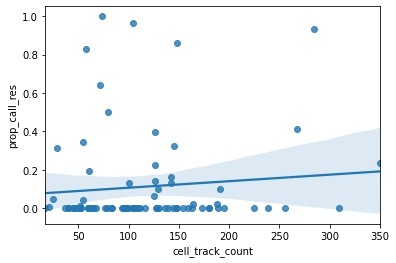

In [52]:
plt.figure()
sbn.regplot(x='cell_track_count', y='prop_call_res', data=conc_calls[conc_calls.cell_track_count < 500])
plt.show()

# Model variance 

To investigate if replicates produce similar or concordant results. (e.g., same data, same hyper params, different inital conditions or seeds) 

In [53]:
def get_model_variance_stats(nclus, load, sz): 
    
    _ids = run_res[lambda x: (x.nclus==nclus) & (x.load == load) & (x.resample_sz == sz)].run_id
    mvar_ = prob_res[lambda x: x.run_id.isin(_ids)]
    mvar_res = mvar_[['run_id', 'obs_id', 'prob_res']].pivot(columns='run_id', values='prob_res', index='obs_id')
    mvar_mat = mvar_res.corr()

    triu_idx = np.triu_indices(mvar_mat.shape[0], k=1)
    corrs = mvar_mat.values[triu_idx]
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    corr_min = corrs.min()
    corr_max = corrs.max()
    return corr_mean, corr_std, corr_min, corr_max

var_res = {'nclus':[], 'load':[], 'resample_sz':[], 'corr_mean':[], 'corr_std':[], 'corr_min':[], 'corr_max':[]}
for nc in run_res.nclus.unique(): 
    for l in run_res.load.unique(): 
        for sz in run_res.resample_sz.unique(): 
            corr_mean, corr_std, corr_min, corr_max = get_model_variance_stats(nc, l, sz)
            var_res['nclus'].append(nc)
            var_res['load'].append(l)
            var_res['resample_sz'].append(sz)
            var_res['corr_mean'].append(corr_mean)
            var_res['corr_std'].append(corr_std)
            var_res['corr_min'].append(corr_min)
            var_res['corr_max'].append(corr_max)
            
var_res = pd.DataFrame(var_res).assign(corr_min_unit = lambda x: x.corr_min.clip(0,1))
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,20,normalized,75,0.992708,0.003559,0.978229,0.998173,0.978229
1,20,normalized,125,0.987437,0.008604,0.962486,0.998438,0.962486
2,20,normalized,100,0.991250,0.005367,0.968090,0.997940,0.968090
3,20,raw,75,0.989556,0.006124,0.970470,0.998565,0.970470
4,20,raw,125,0.990033,0.006623,0.966192,0.997888,0.966192


In [54]:
lm = logit('corr_min_unit ~ nclus + resample_sz + load', data=var_res).fit() #Specify C for Categorical
print(lm.params)
print()
print(lm.conf_int())
#print()
#print(sm.stats.anova_lm(lm))

Optimization terminated successfully.
         Current function value: 0.035275
         Iterations 8
Intercept      4.487377
load[T.raw]    0.294953
nclus         -0.038441
resample_sz   -0.006378
dtype: float64

                    0          1
Intercept   -7.565881  16.540635
load[T.raw] -4.083781   4.673687
nclus       -0.380943   0.304061
resample_sz -0.113221   0.100465


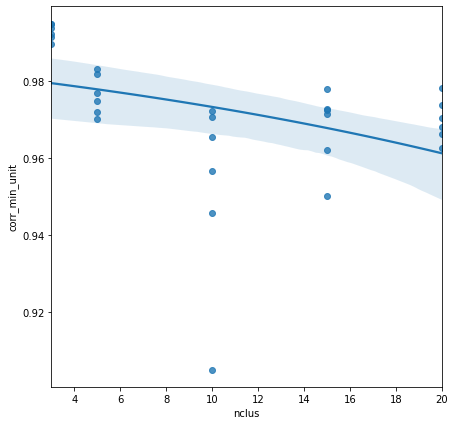

In [55]:
plt.figure(figsize=(7,7))
sbn.regplot(x='nclus', y='corr_min_unit', data=var_res, logistic=True)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


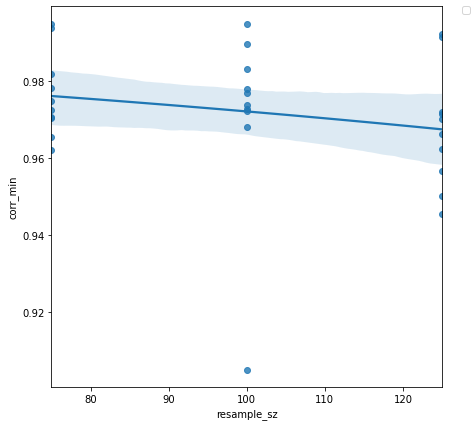

In [56]:
plt.figure(figsize=(7,7))
sbn.regplot(x='resample_sz', y='corr_min', data=var_res, logistic=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


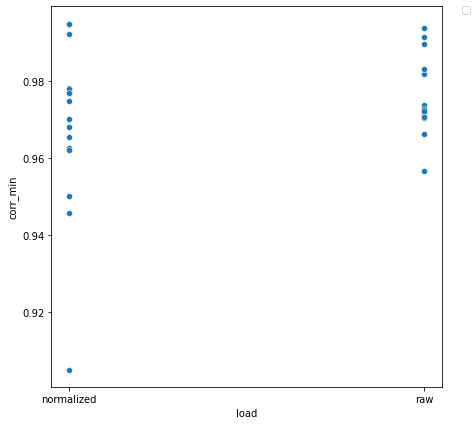

In [57]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='load', y='corr_min', data=var_res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Stable Configs


In [58]:
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,20,normalized,75,0.992708,0.003559,0.978229,0.998173,0.978229
1,20,normalized,125,0.987437,0.008604,0.962486,0.998438,0.962486
2,20,normalized,100,0.991250,0.005367,0.968090,0.997940,0.968090
3,20,raw,75,0.989556,0.006124,0.970470,0.998565,0.970470
4,20,raw,125,0.990033,0.006623,0.966192,0.997888,0.966192


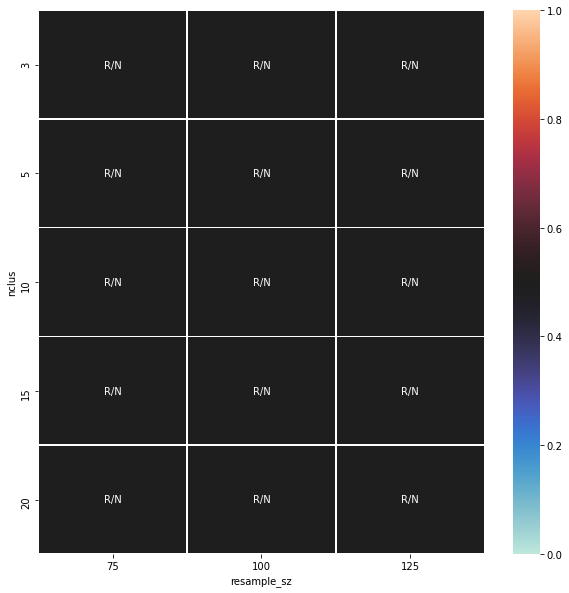

In [59]:
var_res2 = var_res[lambda x: x.corr_min > 0.85][['resample_sz', 'nclus', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()
var_mat = var_res2.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in var_res2.load])
labels = var_res2.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in var_res2.load]).pivot(columns='resample_sz', index='nclus', values='load')
var_mat = var_mat.pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(var_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

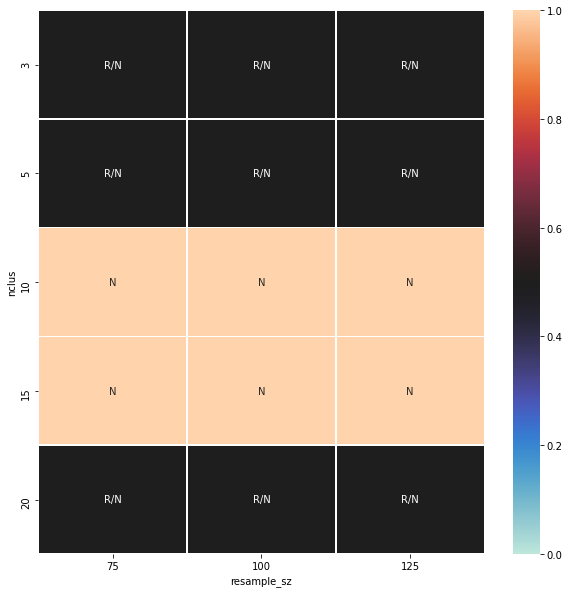

In [60]:
hi_ac = run_res.groupby(['nclus', 'resample_sz', 'load']).agg('mean')[['accuracy(train)']][lambda x: x['accuracy(train)'] == 1.]

hi_ac = hi_ac.reset_index()[['nclus', 'resample_sz', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()

acc_mat = hi_ac.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')
labels = hi_ac.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(acc_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()